In [2]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 16.4 MB/s eta 0:00:00


In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

*   Φορτώνουμε το περιβάλλον στο οποίο το μοντέλο θα εκπαιδευτεί και ρυθμίζουμε το matplotlib, έτσι ώστε να βλέπουμε την εξέλιξη του μοντέλου. Επίσης δίνουμε την επιλογή στο χρήστη να χρησιμοποιήσει την δική του μέθοδο υπολογισμού του μοντέλου, ανάλογο με την διαθέσιμη τεχνολογία που διαθέτει.

In [4]:
env = gym.make("CartPole-v1")

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

*    Replay Memory: Θα χρησιμοποιήσουμε αυτή την τεχνολογία έτσι ώστε  ο πράκτορας να αποκτήσει εμπειρία. Για αυτό το λόγο θα αποθηκεύουμε τις αλλαγές του περιβάλλοντος, για να μπορούμε να τις χρησιμοποιήσουμε ξανά. Αποτέλεσμα αυτού είναι ο πράκτορας σταδιακά να εκπαιδευτεί στις καλύτερες δυνατές ενέργειες.

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


*  Σε αυτό το σημείο δημιουργούνται 4 διαφορετικά νευρωνικά δίκτυα για δοκιμές. Το δίκτυο παίρνει τις 4 παρατηρήσεις του περιβάλλοντος (θέση της βάσης, ταχύτητα της βάσης, γωνία της ράβδου, γωνιακή ταχύτητα της ράβδου) και στη συνέχεια τα στέλνει σε πολλούς νευρώνες. Ως αποτέλεσμα παίρνει την δράση που πρέπει να κάνει, δεξιά ή αριστερά. Όλα τα δίκτυα έχουν ως συνάρτηση ενεργοποίησης την ReLU.

---



1.   Νευρωνικό Δίκτυο 4 ✖ 32 ✖ 32 ✖ 32 ✖ 2




In [6]:
class Deep_Net32(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Deep_Net32, self).__init__()
        self.layer1 = nn.Linear(n_observations, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

2.   Νευρωνικό Δίκτυο 4 ✖ 64 ✖ 64 ✖ 64 ✖ 2

In [7]:
class Deep_Net64(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Deep_Net64, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

3.   Νευρωνικό Δίκτυο 4 ✖ 128 ✖ 128 ✖ 128 ✖ 2

In [8]:
class Deep_Net128(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Deep_Net128, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

4.   Νευρωνικό Δίκτυο 4 ✖ 32 ✖ 64 ✖ 128 ✖ 2

In [9]:
class Deep_Net_Max(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Deep_Net_Max, self).__init__()
        self.layer1 = nn.Linear(n_observations, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 128)
        self.layer4 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

*   Αρχικοποιούμε το μοντέλο και τον optimizer

In [10]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net32(n_observations, n_actions).to(device)
target_net = Deep_Net32(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


* Δημιουργούμε μια συνάρτηση select_action η οποία επιλέγει μία τυχαία δράση ή μία δράση απότο μοντέλο. Αυτή η διαδικασία βοηθάει στην εξερεύνηση με την χρήση των τυχαίων δράσεων και στην εκμετάλευση με την χρήση αυτών που επιλέγει το μοντέλο.
* Δημιουγρία της συνάρτησης plot_durations το οποίο μας δείχνει σε γράφημα πόσο διαρκεί το κάθε επεισόδιο.

In [11]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
 
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

* Παρακάτω βλέπουμε την εκπαίδευση του μοντέλου. Περιέχει ένα βήμα της βελτιστοποίησης. Θα δημιουργήσουμε δύο ίδιες συναρτήσεις με μόνη διαφορά την συνάρτηση σφάλματος, όπου στη μία περίπτωση είναι η Huber Loss και στην άλλη το Mean Squared Error Loss.

---

1.  Huber Loss

In [12]:
def optimize_model_Huber():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

 
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
  
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

2. Mean Squared Error Loss

In [13]:
def optimize_model_MSE():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

 
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
  
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

* Σε αυτό το σημείο ξεκινάει η εκπαίδευση. Θα συνδυάσουμε τους διαφορετικούς τύπους νευρωνικών δικτύων με τις δύο διαφορετικές συναρτήσεις σφάλματος

---
1. Deep_Net32 και Huber Loss


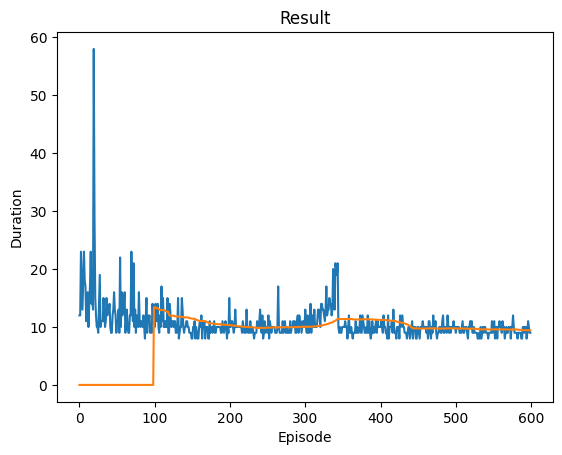

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_Huber()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()


2. Deep_Net64 και Huber Loss

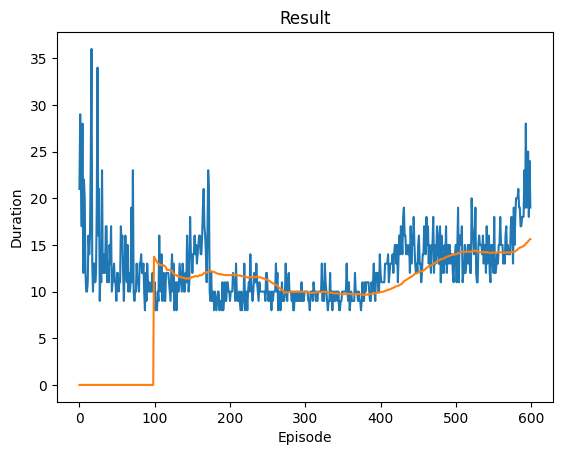

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net64(n_observations, n_actions).to(device)
target_net = Deep_Net64(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_Huber()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()

3. Deep_Net128 και Huber Loss

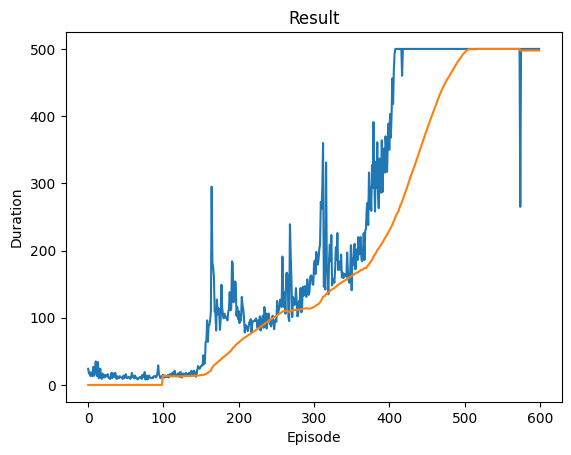

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net128(n_observations, n_actions).to(device)
target_net = Deep_Net128(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_Huber()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()

4. Deep_Net_Max και Huber Loss

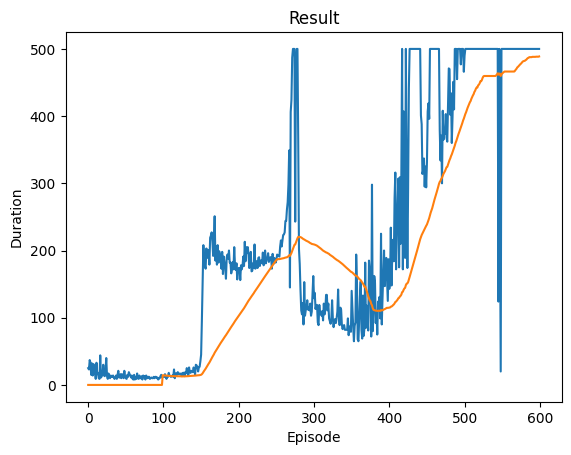

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net_Max(n_observations, n_actions).to(device)
target_net = Deep_Net_Max(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_Huber()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()

5. Deep_Net32 και MSE Loss

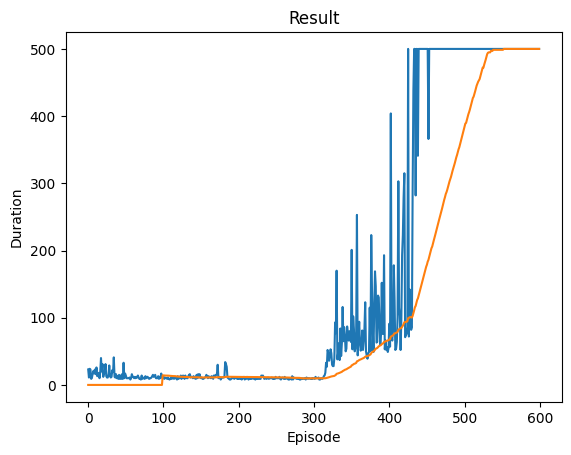

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net32(n_observations, n_actions).to(device)
target_net = Deep_Net32(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_MSE()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()

6. Deep_Net64 και MSE Loss

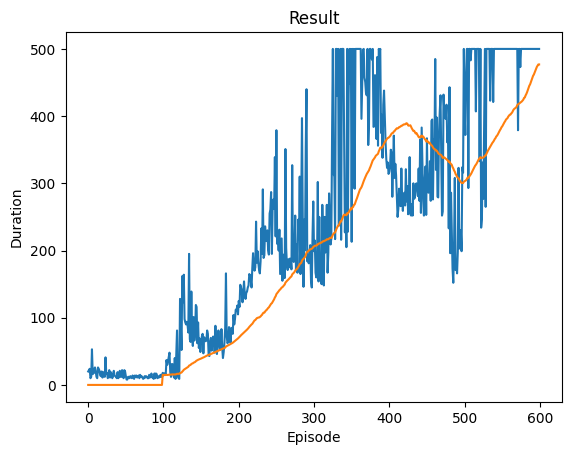

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net64(n_observations, n_actions).to(device)
target_net = Deep_Net64(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_MSE()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()

7. Deep_Net128 και MSE Loss

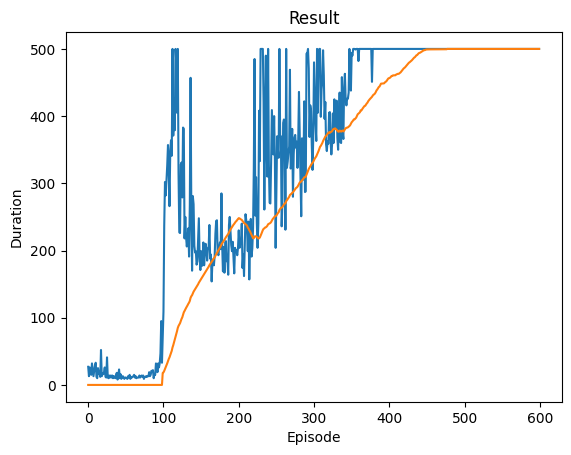

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net128(n_observations, n_actions).to(device)
target_net = Deep_Net128(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_MSE()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()

8. Deep_Net_Max και MSE Loss

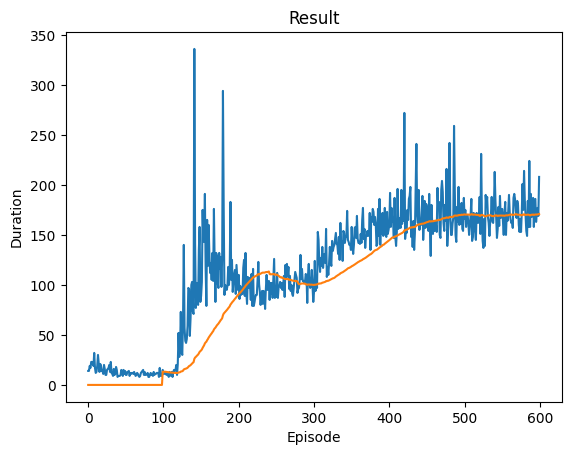

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net_Max(n_observations, n_actions).to(device)
target_net = Deep_Net_Max(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_MSE()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()

*  Τώρα θα εξετάσουμε τα ίδια παραδείγματα με διαφορετικές τιμές στο GAMMA και στο EPSILON. Το πρώτο ρυθμίζει το κατά πόσο το μοντέλο θα λαμβάνει υπόψη του τα κοντινότερα ή τα μακρυνότερα rewards, ενώ το δεύτερο ελέγχει το ποσοστό της εξερεύνησης προς την εκμετάλευση.

In [22]:
BATCH_SIZE = 128
GAMMA = 0.5
EPS_START = 0.5
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

1. Deep_Net32 και Huber Loss

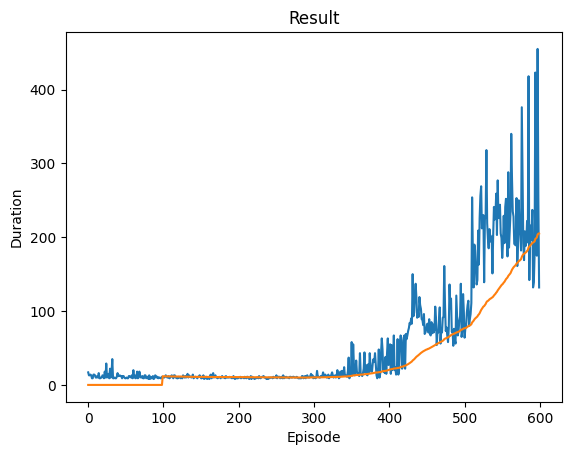

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [23]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net32(n_observations, n_actions).to(device)
target_net = Deep_Net32(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_Huber()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()

2. Deep_Net64 και Huber Loss

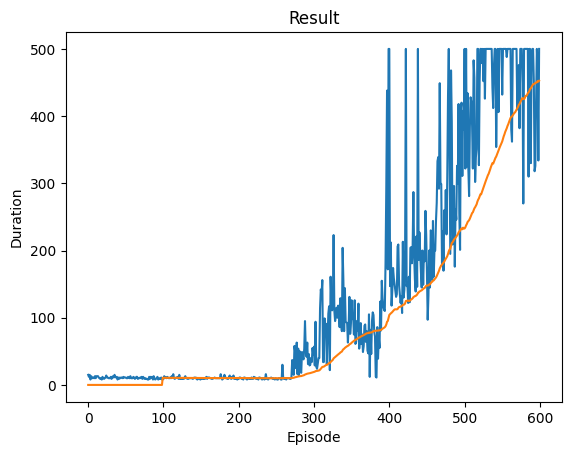

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net64(n_observations, n_actions).to(device)
target_net = Deep_Net64(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_Huber()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()

3. Deep_Net128 και Huber Loss

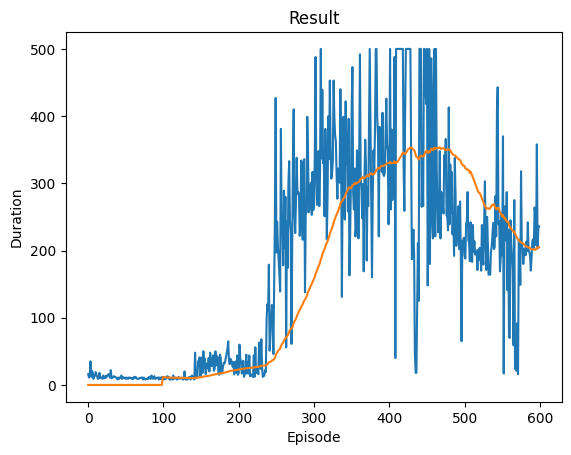

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [25]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net128(n_observations, n_actions).to(device)
target_net = Deep_Net128(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_Huber()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()

4. Deep_Net_Max και Huber Loss

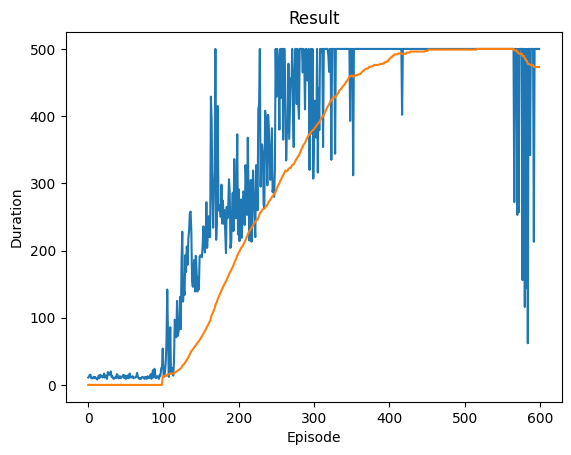

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [26]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net_Max(n_observations, n_actions).to(device)
target_net = Deep_Net_Max(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_Huber()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()

5. Deep_Net32 και MSE Loss

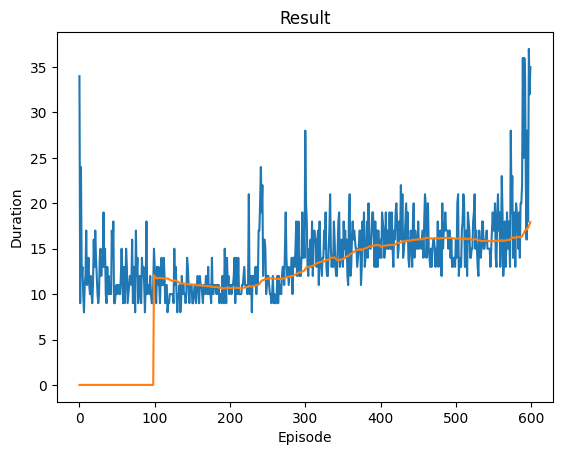

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [27]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net32(n_observations, n_actions).to(device)
target_net = Deep_Net32(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_MSE()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()

6. Deep_Net64 και MSE Loss

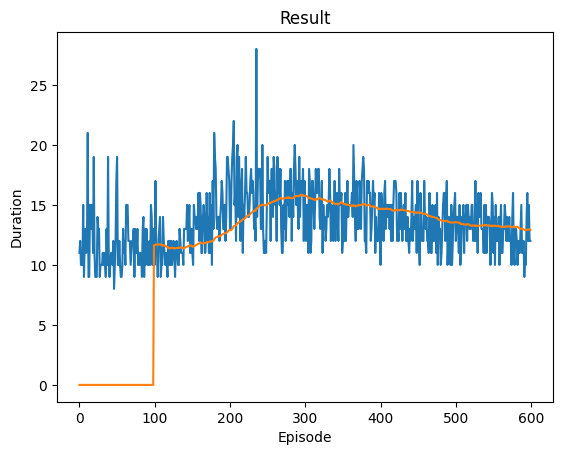

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [28]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net64(n_observations, n_actions).to(device)
target_net = Deep_Net64(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_MSE()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()

7. Deep_Net128 και MSE Loss

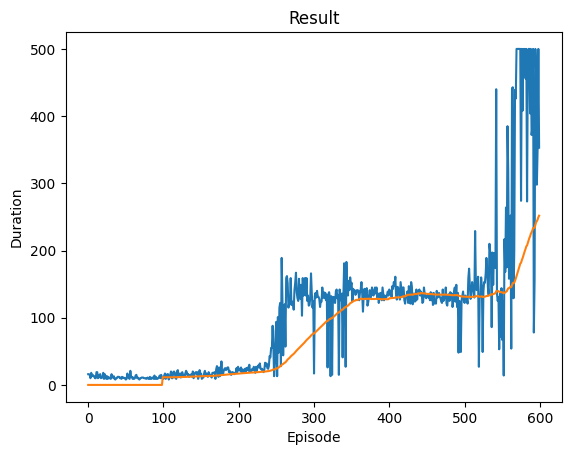

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [29]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net128(n_observations, n_actions).to(device)
target_net = Deep_Net128(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_MSE()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()

8. Deep_Net_Max και MSE Loss

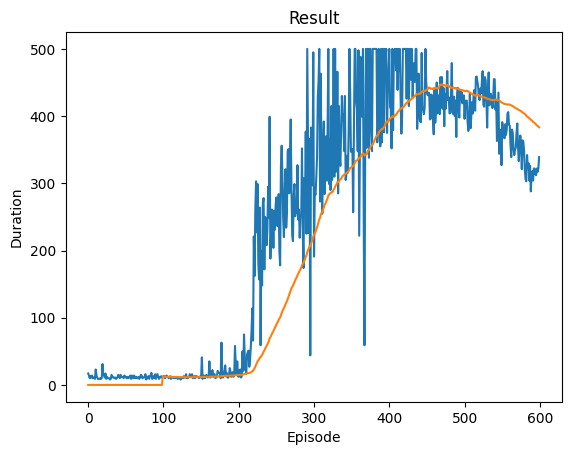

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [30]:
episode_durations = []
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = Deep_Net_Max(n_observations, n_actions).to(device)
target_net = Deep_Net_Max(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model_MSE()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
plot_durations(show_result=True)
plt.ioff()
plt.show()